In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict
from DataPreprocess import preprocess_dataset

## Load dataset

In [2]:
X_train = np.load('datasets/X_train.npy')
y_train = np.load('datasets/y_train.npy')
X_val = np.load('datasets/X_val.npy')
y_val = np.load('datasets/y_val.npy')

In [3]:
# Print shapes for verification
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")

X_train shape: (1587, 100, 9)
X_val shape: (397, 100, 9)
y_train shape: (1587,)
y_val shape: (397,)


In [4]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# Adjust weight for positive class (e.g., reduce by 25%)
class_weight_dict[1] = class_weight_dict[1] * 0.75
print("Adjusted class weights:", class_weight_dict)

Adjusted class weights: {0: 0.5272425249169436, 1: 7.257621951219512}


## LSTM

In [5]:
# LSTM - Lightweight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU, Input, Dropout
from tensorflow.keras.regularizers import l2

max_len = 100
n_features = 9

lstm_model = Sequential([
    Input(shape=(max_len, n_features)),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

lstm_model.summary()

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'precision', 'recall'])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,057 (82.25 KB)

 Trainable params: 21,057 (82.25 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
history_lstm = lstm_model.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val), 
    epochs=10, 
    batch_size=32,
    verbose=1,
    class_weight=class_weight_dict
)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8683 - loss: 0.6304 - precision: 0.1609 - recall: 0.3317 - val_accuracy: 0.7305 - val_loss: 0.3570 - val_precision: 0.1532 - val_recall: 0.9048
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7345 - loss: 0.4557 - precision: 0.1723 - recall: 0.9122 - val_accuracy: 0.7305 - val_loss: 0.3868 - val_precision: 0.1532 - val_recall: 0.9048
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7218 - loss: 0.4478 - precision: 0.1737 - recall: 0.9063 - val_accuracy: 0.7330 - val_loss: 0.3652 - val_precision: 0.1545 - val_recall: 0.9048
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7480 - loss: 0.3966 - precision: 0.1769 - recall: 0.9159 - val_accuracy: 0.7355 - val_loss: 0.3554 - val_precision: 0.1557 - val_recall: 0.9048
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7685 - loss: 0.3186 - precision: 0.1509 - recall: 0.9321 - val_accuracy: 0.7582 - val_loss: 0.3622 

In [7]:
# # LSTM - Deeper network
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, GRU, Input, Dropout

# lstm_model = Sequential([
#     Input(shape=(max_len, n_features)),
#     LSTM(128, return_sequences=True),
#     LSTM(64, return_sequences=False),
#     Dense(32, activation='relu'),
#     Dense(16, activation='relu'),
#     Dense(1, activation='sigmoid')
# ])

# lstm_model.summary()

# lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [8]:
# history_lstm = lstm_model.fit(
#     X_train, 
#     y_train, 
#     validation_data=(X_val, y_val), 
#     epochs=10, 
#     batch_size=32,
#     verbose=1,
#     class_weight=class_weight_dict
# )

In [9]:
# LSTM - Make predictions
y_pred_prob_lstm = lstm_model.predict(X_val)
y_pred_lstm = (y_pred_prob_lstm > 0.5).astype(int).flatten()

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [10]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix

# Compute evaluation metrics
auc_roc = roc_auc_score(y_val, y_pred_prob_lstm)
precision = precision_score(y_val, y_pred_lstm)
recall = recall_score(y_val, y_pred_lstm)
f1 = f1_score(y_val, y_pred_lstm)

# Print metrics
print("LSTM Models")
print("="*30)
print(f"AUC-ROC: {auc_roc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

LSTM Models
AUC-ROC: 0.8849
Precision: 0.1845
Recall: 0.9048
F1-Score: 0.3065


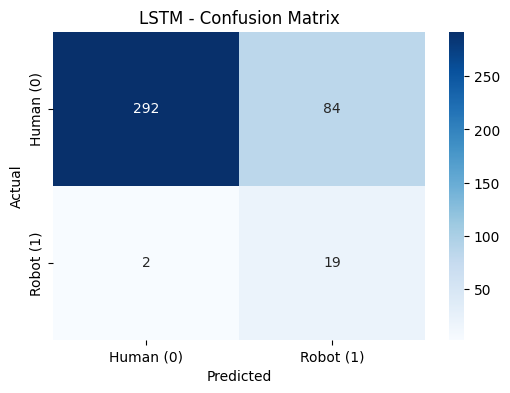

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# LSTM - Compute and plot confusion matrix
cm_lstm = confusion_matrix(y_val, y_pred_lstm)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Human (0)', 'Robot (1)'],
            yticklabels=['Human (0)', 'Robot (1)'])
plt.title('LSTM - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

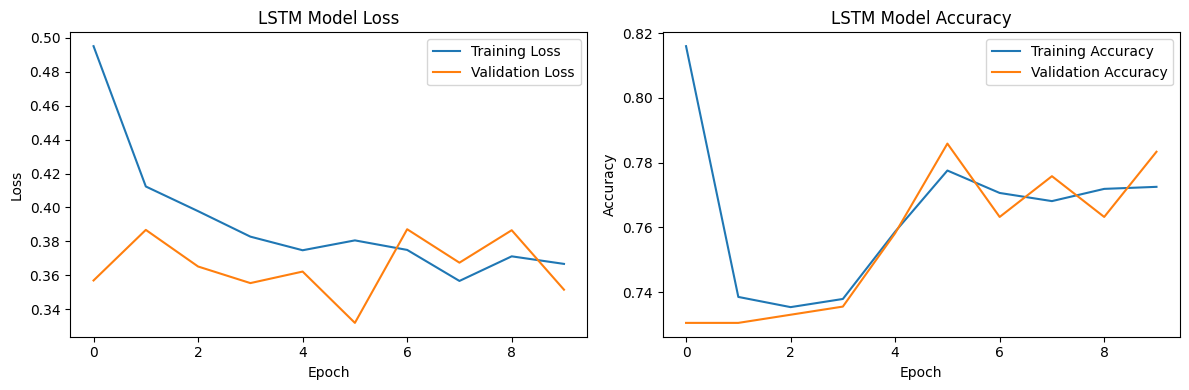

In [12]:
# Optional: LSTM - Plot training history (loss and accuracy)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['accuracy'], label='Training Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
# Make predictions
y_train_pred_prob_lstm = lstm_model.predict(X_train)
y_test_pred_prob_lstm = lstm_model.predict(X_val)
y_train_pred_lstm = (y_train_pred_prob_lstm > 0.5).astype(int).flatten()
y_test_pred_lstm = (y_test_pred_prob_lstm > 0.5).astype(int).flatten()

# Compute evaluation metrics for training and test sets
metrics = {
    'AUC-ROC': [roc_auc_score(y_train, y_train_pred_prob_lstm), roc_auc_score(y_val, y_test_pred_prob_lstm)],
    'Precision': [precision_score(y_train, y_train_pred_lstm), precision_score(y_val, y_test_pred_lstm)],
    'Recall': [recall_score(y_train, y_train_pred_lstm), recall_score(y_val, y_test_pred_lstm)],
    'F1-Score': [f1_score(y_train, y_train_pred_lstm), f1_score(y_val, y_test_pred_lstm)]
}

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


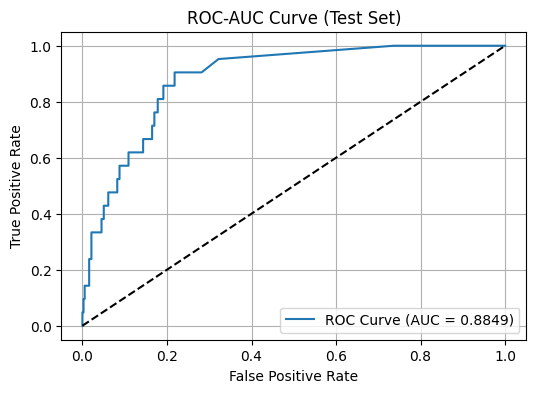

In [14]:
from sklearn.metrics import roc_curve, precision_recall_curve


# Plot ROC-AUC Curve
fpr, tpr, _ = roc_curve(y_val, y_pred_prob_lstm)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {metrics["AUC-ROC"][1]:.4f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.title('ROC-AUC Curve (Test Set)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.savefig('findings/lstm_roc_auc_curve.png')
plt.show()
plt.close()

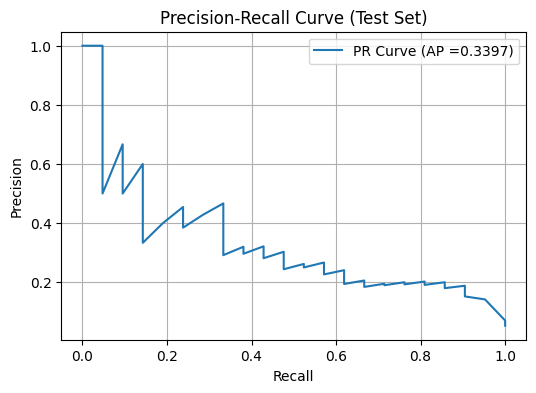

In [15]:
from sklearn.metrics import average_precision_score

# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_val, y_test_pred_prob_lstm)
ap_score = average_precision_score(y_val, y_test_pred_prob_lstm)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f'PR Curve (AP ={ap_score:.4f})')
plt.title('Precision-Recall Curve (Test Set)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.savefig('findings/lstm_precision_recall_curve.png')
plt.show()
plt.close()

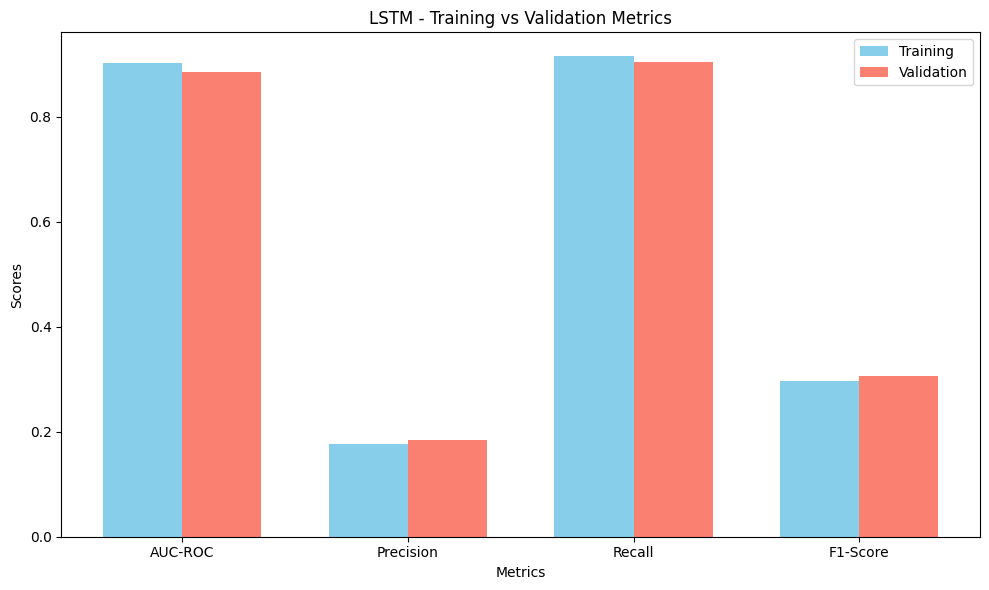

In [16]:
# Plot training vs validation bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(metrics))

ax.bar(index, [metrics[m][0] for m in metrics], bar_width, label='Training', color='skyblue')
ax.bar(index + bar_width, [metrics[m][1] for m in metrics], bar_width, label='Validation', color='salmon')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('LSTM - Training vs Validation Metrics')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(metrics.keys())
ax.legend()
plt.tight_layout()
plt.savefig('findings/lstm_training_vs_validation_metrics.png')
plt.show()
plt.close()

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Threshold: 0.50, Precision: 0.184, Recall: 0.905, F1: 0.306
Threshold: 0.55, Precision: 0.184, Recall: 0.857, F1: 0.303
Threshold: 0.60, Precision: 0.195, Recall: 0.810, F1: 0.315
Threshold: 0.65, Precision: 0.190, Recall: 0.714, F1: 0.300
Threshold: 0.70, Precision: 0.250, Recall: 0.524, F1: 0.338
Threshold: 0.75, Precision: 0.368, Recall: 0.333, F1: 0.350
Threshold: 0.80, Precision: 0.333, Recall: 0.143, F1: 0.200
Threshold: 0.85, Precision: 0.500, Recall: 0.095, F1: 0.160


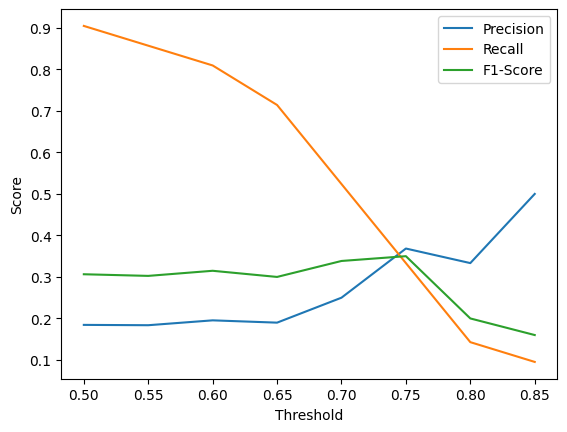

Optimal Threshold: 0.75
Final Precision: 0.368
Final Recall: 0.333
Final F1-Score: 0.350


In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

# Get predicted probabilities
y_pred_proba = lstm_model.predict(X_val)

# Evaluate different thresholds
thresholds = np.arange(0.5, 0.9, 0.05)
precisions, recalls, f1_scores = [], [], []
for thresh in thresholds:
    y_pred = (y_pred_proba > thresh).astype(int)
    precisions.append(precision_score(y_val, y_pred))
    recalls.append(recall_score(y_val, y_pred))
    f1_scores.append(f1_score(y_val, y_pred))
    print(f"Threshold: {thresh:.2f}, Precision: {precisions[-1]:.3f}, Recall: {recalls[-1]:.3f}, F1: {f1_scores[-1]:.3f}")

# Plot precision-recall trade-off
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1_scores, label='F1-Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

# Choose optimal threshold (e.g., maximizing F1 or precision with acceptable recall)
optimal_threshold = thresholds[np.argmax(f1_scores)]  # Or manually select based on precision-recall balance
y_pred_optimal = (y_pred_proba > optimal_threshold).astype(int)
print(f"Optimal Threshold: {optimal_threshold:.2f}")
print(f"Final Precision: {precision_score(y_val, y_pred_optimal):.3f}")
print(f"Final Recall: {recall_score(y_val, y_pred_optimal):.3f}")
print(f"Final F1-Score: {f1_score(y_val, y_pred_optimal):.3f}")

### Testing on Test set

In [20]:
X_test = np.load('datasets/X_test.npy')

In [21]:
X_test.shape

(4630, 100, 9)

In [23]:
# LSTM - Make predictions
y_pred_prob_lstm = lstm_model.predict(X_test)
y_pred_lstm = (y_pred_prob_lstm > 0.5).astype(int).flatten()

145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [28]:
y_pred_prob_lstm.shape

(4630, 1)

In [29]:
y_pred_series = pd.Series(y_pred_prob_lstm.reshape(-1), name='prediction') 
y_pred_series

0       0.056544
1       0.056544
2       0.056544
3       0.056403
4       0.684370
          ...   
4625    0.056544
4626    0.798780
4627    0.681936
4628    0.056544
4629    0.676733
Name: prediction, Length: 4630, dtype: float32

In [32]:
bidder_ids = np.load('datasets/bidders_ids.npy')
df = pd.DataFrame(bidder_ids, columns=['bidder_id'])

In [34]:
df['outcome'] = y_pred_series

In [35]:
df.head()

,bidder_id,outcome
0,002d229ffb247009810828f648afc2ef593rb,0.056544
1,003180b29c6a5f8f1d84a6b7b6f7be57tjj1o,0.056544
2,00486a11dff552c4bd7696265724ff81yeo9v,0.056544
3,0051aef3fdeacdadba664b9b3b07e04e4coc6,0.056403
4,0053b78cde37c4384a20d2da9aa4272aym4pb,0.684370


In [37]:
# bidder ids with missing columns -- assumes to be human
na_bidders = pd.read_csv('datasets/bidder_ids_na.csv')
na_bidders.head()

,bidder_id
0,b24e3af20453813e821f5a22ff55e072tgton
1,65489e2734f03652a76bf139df96c479lopnf
2,3c465a8c5b93301383617e4c539c850aumt08
3,55a699bd3a83fe99db348c4302ee754ep392w
4,4b24254e994ad8abcc4b5b4020991960q7j30


In [39]:
na_bidders['outcome'] = 0.0
na_bidders.head()

,bidder_id,outcome
0,b24e3af20453813e821f5a22ff55e072tgton,0.0
1,65489e2734f03652a76bf139df96c479lopnf,0.0
2,3c465a8c5b93301383617e4c539c850aumt08,0.0
3,55a699bd3a83fe99db348c4302ee754ep392w,0.0
4,4b24254e994ad8abcc4b5b4020991960q7j30,0.0


In [40]:
print(df.shape)
print(na_bidders.shape)

(4630, 2)
(70, 2)


In [42]:
merged_df = pd.concat([df, na_bidders], axis=0)
print(merged_df.shape)
merged_df.head()

(4700, 2)


,bidder_id,outcome
0,002d229ffb247009810828f648afc2ef593rb,0.056544
1,003180b29c6a5f8f1d84a6b7b6f7be57tjj1o,0.056544
2,00486a11dff552c4bd7696265724ff81yeo9v,0.056544
3,0051aef3fdeacdadba664b9b3b07e04e4coc6,0.056403
4,0053b78cde37c4384a20d2da9aa4272aym4pb,0.684370


In [44]:
# Output 1: LSTM_submission.csv
merged_df.to_csv("result/lstm_submission.csv")

## GRU

In [45]:
# # Example of how to use in GRU

gru_model = Sequential([
    Input(shape=(max_len, n_features)),
    GRU(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

gru_model.summary()

gru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'precision', 'recall'])

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                     │ (None, 64)             │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,513 (64.50 KB)

 Trainable params: 16,513 (64.50 KB)

 Non-trainable params: 0 (0.00 B)

In [46]:
history_gru = gru_model.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val), 
    epochs=10, 
    batch_size=32,
    verbose=1,
    class_weight=class_weight_dict
)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7568 - loss: 0.5940 - precision: 0.1899 - recall: 0.8480 - val_accuracy: 0.7783 - val_loss: 0.4445 - val_precision: 0.1810 - val_recall: 0.9048
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7898 - loss: 0.3553 - precision: 0.2002 - recall: 0.9214 - val_accuracy: 0.8060 - val_loss: 0.2841 - val_precision: 0.1889 - val_recall: 0.8095
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7989 - loss: 0.4499 - precision: 0.2029 - recall: 0.7776 - val_accuracy: 0.7909 - val_loss: 0.3183 - val_precision: 0.1900 - val_recall: 0.9048
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7633 - loss: 0.3919 - precision: 0.1479 - recall: 0.7943 - val_accuracy: 0.7859 - val_loss: 0.3288 - val_precision: 0.1863 - val_recall: 0.9048
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7773 - loss: 0.3704 - precision: 0.1699 - recall: 0.8987 - val_accuracy: 0.7582 - val_loss: 0.4207 

In [47]:
y_pred_prob_gru = gru_model.predict(X_val)
y_pred_gru = (y_pred_prob_gru > 0.5).astype(int).flatten()

# Compute evaluation metrics
auc_roc_2 = roc_auc_score(y_val, y_pred_prob_gru)
precision_2 = precision_score(y_val, y_pred_gru)
recall_2 = recall_score(y_val, y_pred_gru)
f1_2 = f1_score(y_val, y_pred_gru)

# Print metrics
print("GRU Models")
print("="*30)
print(f"AUC-ROC: {auc_roc_2:.4f}")
print(f"Precision: {precision_2:.4f}")
print(f"Recall: {recall_2:.4f}")
print(f"F1-Score: {f1_2:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
GRU Models
AUC-ROC: 0.8737
Precision: 0.1776
Recall: 0.9048
F1-Score: 0.2969


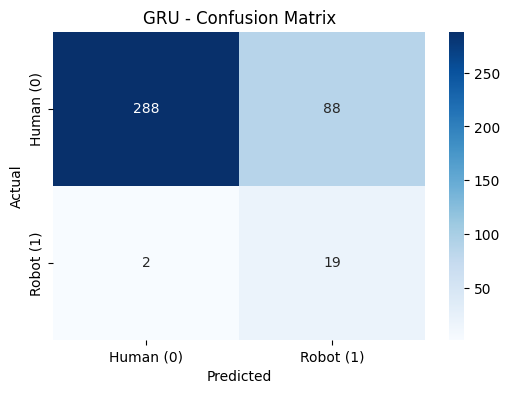

In [48]:
# GRU - Compute and plot confusion matrix
cm_2 = confusion_matrix(y_val, y_pred_gru)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_2, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Human (0)', 'Robot (1)'],
            yticklabels=['Human (0)', 'Robot (1)'])
plt.title('GRU - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

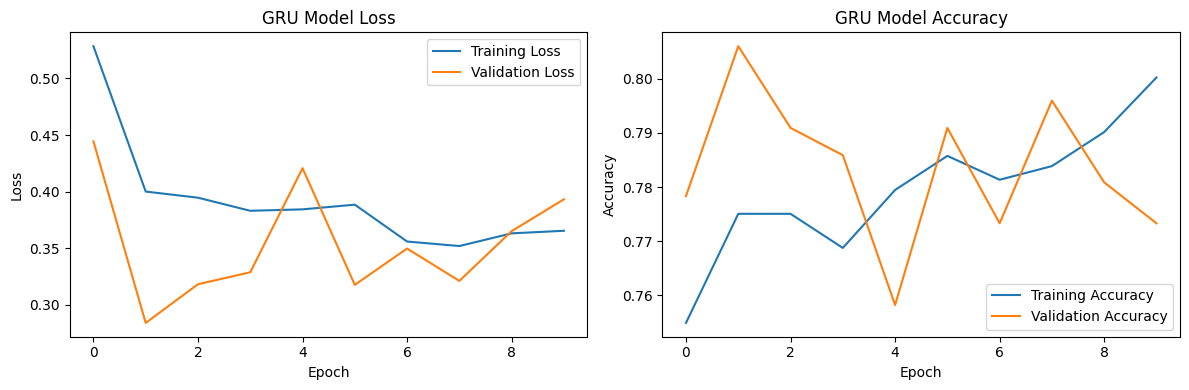

In [49]:
# Optional: GRU - Plot training history (loss and accuracy)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_gru.history['loss'], label='Training Loss')
plt.plot(history_gru.history['val_loss'], label='Validation Loss')
plt.title('GRU Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_gru.history['accuracy'], label='Training Accuracy')
plt.plot(history_gru.history['val_accuracy'], label='Validation Accuracy')
plt.title('GRU Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [50]:
# Make predictions
y_train_pred_prob_gru = gru_model.predict(X_train)
y_val_pred_prob_gru = gru_model.predict(X_val)
y_train_pred_gru = (y_train_pred_prob_gru > 0.5).astype(int).flatten()
y_val_pred_gru = (y_val_pred_prob_gru > 0.5).astype(int).flatten()

# Compute evaluation metrics for training and test sets
metrics_gru = {
    'AUC-ROC': [roc_auc_score(y_train, y_train_pred_prob_gru), roc_auc_score(y_val, y_val_pred_prob_gru)],
    'Precision': [precision_score(y_train, y_train_pred_gru), precision_score(y_val, y_val_pred_gru)],
    'Recall': [recall_score(y_train, y_train_pred_gru), recall_score(y_val, y_val_pred_gru)],
    'F1-Score': [f1_score(y_train, y_train_pred_gru), f1_score(y_val, y_val_pred_gru)]
}

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


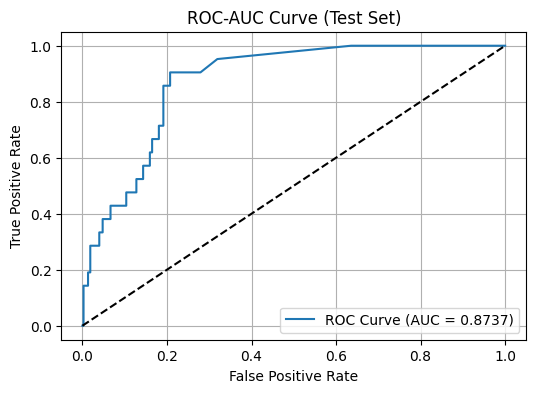

In [51]:
from sklearn.metrics import roc_curve, precision_recall_curve


# Plot ROC-AUC Curve
fpr, tpr, _ = roc_curve(y_val, y_pred_prob_gru)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {metrics_gru["AUC-ROC"][1]:.4f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.title('ROC-AUC Curve (Test Set)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.savefig('findings/gru_roc_auc_curve.png')
plt.show()
plt.close()

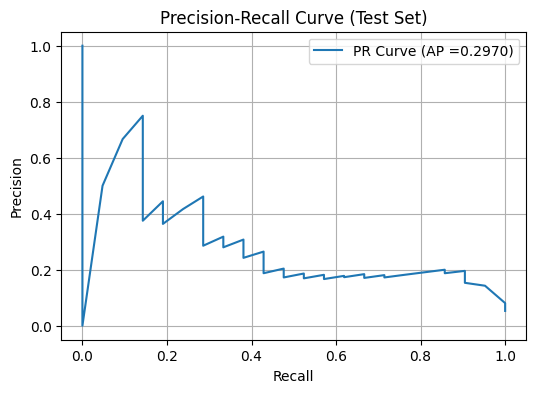

In [52]:
from sklearn.metrics import average_precision_score

# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_val, y_val_pred_prob_gru)
ap_score = average_precision_score(y_val, y_val_pred_prob_gru)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f'PR Curve (AP ={ap_score:.4f})')
plt.title('Precision-Recall Curve (Test Set)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.savefig('findings/gru_precision_recall_curve.png')
plt.show()
plt.close()

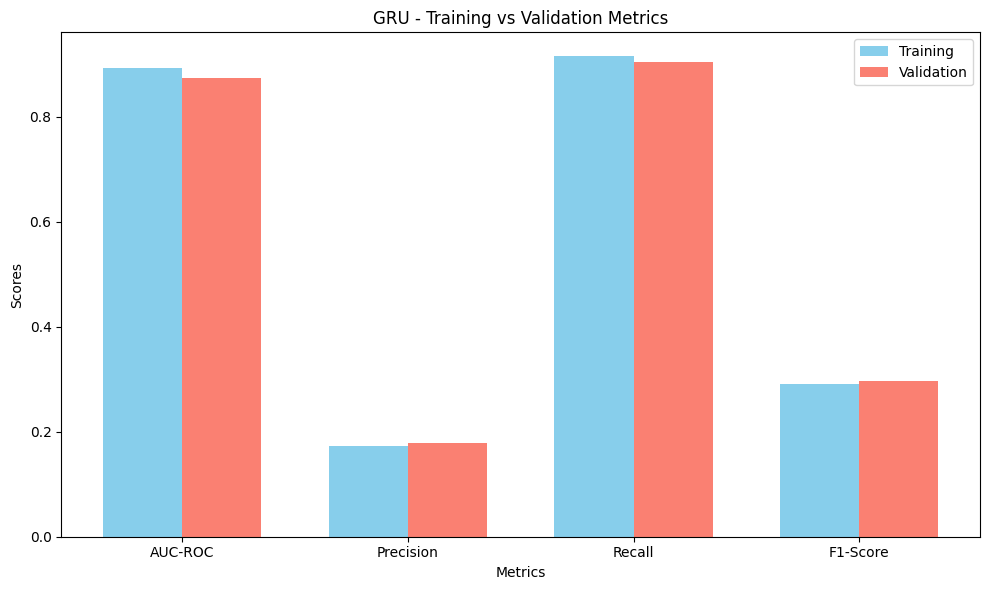

In [53]:
# Plot training vs validation bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(metrics_gru))

ax.bar(index, [metrics_gru[m][0] for m in metrics_gru], bar_width, label='Training', color='skyblue')
ax.bar(index + bar_width, [metrics_gru[m][1] for m in metrics_gru], bar_width, label='Validation', color='salmon')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('GRU - Training vs Validation Metrics')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(metrics_gru.keys())
ax.legend()
plt.tight_layout()
plt.savefig('findings/gru_training_vs_validation_metrics.png')
plt.show()
plt.close()

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Threshold: 0.50, Precision: 0.178, Recall: 0.905, F1: 0.297
Threshold: 0.55, Precision: 0.186, Recall: 0.905, F1: 0.309
Threshold: 0.60, Precision: 0.194, Recall: 0.857, F1: 0.316
Threshold: 0.65, Precision: 0.174, Recall: 0.714, F1: 0.280
Threshold: 0.70, Precision: 0.179, Recall: 0.571, F1: 0.273
Threshold: 0.75, Precision: 0.200, Recall: 0.476, F1: 0.282
Threshold: 0.80, Precision: 0.304, Recall: 0.333, F1: 0.318
Threshold: 0.85, Precision: 0.375, Recall: 0.143, F1: 0.207


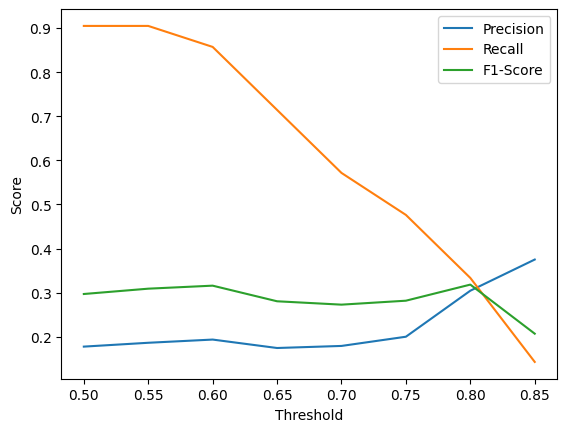

Optimal Threshold: 0.80
Final Precision: 0.304
Final Recall: 0.333
Final F1-Score: 0.318


In [54]:
# Get predicted probabilities
y_pred_proba = gru_model.predict(X_val)

# Evaluate different thresholds
thresholds = np.arange(0.5, 0.9, 0.05)
precisions, recalls, f1_scores = [], [], []
for thresh in thresholds:
    y_pred = (y_pred_proba > thresh).astype(int)
    precisions.append(precision_score(y_val, y_pred))
    recalls.append(recall_score(y_val, y_pred))
    f1_scores.append(f1_score(y_val, y_pred))
    print(f"Threshold: {thresh:.2f}, Precision: {precisions[-1]:.3f}, Recall: {recalls[-1]:.3f}, F1: {f1_scores[-1]:.3f}")

# Plot precision-recall trade-off
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1_scores, label='F1-Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

# Choose optimal threshold (e.g., maximizing F1 or precision with acceptable recall)
optimal_threshold = thresholds[np.argmax(f1_scores)]  # Or manually select based on precision-recall balance
y_pred_optimal = (y_pred_proba > optimal_threshold).astype(int)
print(f"Optimal Threshold: {optimal_threshold:.2f}")
print(f"Final Precision: {precision_score(y_val, y_pred_optimal):.3f}")
print(f"Final Recall: {recall_score(y_val, y_pred_optimal):.3f}")
print(f"Final F1-Score: {f1_score(y_val, y_pred_optimal):.3f}")

### Testing on GRU model

In [55]:
X_test = np.load('datasets/X_test.npy')
X_test.shape

(4630, 100, 9)

In [56]:
# GRU - Make predictions
y_pred_prob_gru = gru_model.predict(X_test)
y_pred_gru = (y_pred_prob_gru > 0.5).astype(int).flatten()

145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [57]:
y_pred_gru.shape

(4630,)

In [58]:
y_pred_series = pd.Series(y_pred_prob_gru.reshape(-1), name='prediction') 
y_pred_series

0       0.064569
1       0.064569
2       0.064569
3       0.064551
4       0.728981
          ...   
4625    0.064569
4626    0.855787
4627    0.735351
4628    0.064569
4629    0.756352
Name: prediction, Length: 4630, dtype: float32

In [59]:
bidder_ids = np.load('datasets/bidders_ids.npy')
df = pd.DataFrame(bidder_ids, columns=['bidder_id'])
df['outcome'] = y_pred_series

In [60]:
print(df.shape)
df.head()

(4630, 2)


,bidder_id,outcome
0,002d229ffb247009810828f648afc2ef593rb,0.064569
1,003180b29c6a5f8f1d84a6b7b6f7be57tjj1o,0.064569
2,00486a11dff552c4bd7696265724ff81yeo9v,0.064569
3,0051aef3fdeacdadba664b9b3b07e04e4coc6,0.064551
4,0053b78cde37c4384a20d2da9aa4272aym4pb,0.728981


In [61]:
# bidder ids with missing columns -- assumes to be human
na_bidders = pd.read_csv('datasets/bidder_ids_na.csv')
na_bidders['outcome'] = 0.0

print(na_bidders.shape)
na_bidders.head()

(70, 2)


,bidder_id,outcome
0,b24e3af20453813e821f5a22ff55e072tgton,0.0
1,65489e2734f03652a76bf139df96c479lopnf,0.0
2,3c465a8c5b93301383617e4c539c850aumt08,0.0
3,55a699bd3a83fe99db348c4302ee754ep392w,0.0
4,4b24254e994ad8abcc4b5b4020991960q7j30,0.0


In [62]:
# Merge vertically
merged_df = pd.concat([df, na_bidders], axis=0)
print(merged_df.shape)
merged_df.head()

(4700, 2)


,bidder_id,outcome
0,002d229ffb247009810828f648afc2ef593rb,0.064569
1,003180b29c6a5f8f1d84a6b7b6f7be57tjj1o,0.064569
2,00486a11dff552c4bd7696265724ff81yeo9v,0.064569
3,0051aef3fdeacdadba664b9b3b07e04e4coc6,0.064551
4,0053b78cde37c4384a20d2da9aa4272aym4pb,0.728981


In [63]:
# Output 2: GRU prediction
merged_df.to_csv('result/gru_submission.csv')

In [79]:
# CHange column name
df1 = pd.read_csv('result/lstm_submission.csv')
df2 = pd.read_csv('result/gru_submission.csv')

In [80]:
df1['prediction'] = df1['outcome > prediction']
df1 = df1.drop(['outcome > prediction'], axis=1)

df2['prediction'] = df2['outcome > prediction']
df2 = df2.drop(['outcome > prediction'], axis=1)

In [81]:
df1

,bidder_id,prediction
0,002d229ffb247009810828f648afc2ef593rb,0.056544
1,003180b29c6a5f8f1d84a6b7b6f7be57tjj1o,0.056544
2,00486a11dff552c4bd7696265724ff81yeo9v,0.056544
3,0051aef3fdeacdadba664b9b3b07e04e4coc6,0.056403
4,0053b78cde37c4384a20d2da9aa4272aym4pb,0.684370
...,...,...
4695,94bbdc684b0a24abc75adfd110edf0f8jy4ga,0.000000
4696,04f9a93f45c1108baa3c1447ad4ff5a1mqfhx,0.000000
4697,a7b08e5b27861262120310d505f30cb8oxbsu,0.000000
4698,677fe35ddddb143b117f7e36eef3c332ru33r,0.000000


In [82]:
df2

,bidder_id,prediction
0,002d229ffb247009810828f648afc2ef593rb,0.064569
1,003180b29c6a5f8f1d84a6b7b6f7be57tjj1o,0.064569
2,00486a11dff552c4bd7696265724ff81yeo9v,0.064569
3,0051aef3fdeacdadba664b9b3b07e04e4coc6,0.064551
4,0053b78cde37c4384a20d2da9aa4272aym4pb,0.728981
...,...,...
4695,94bbdc684b0a24abc75adfd110edf0f8jy4ga,0.000000
4696,04f9a93f45c1108baa3c1447ad4ff5a1mqfhx,0.000000
4697,a7b08e5b27861262120310d505f30cb8oxbsu,0.000000
4698,677fe35ddddb143b117f7e36eef3c332ru33r,0.000000


In [83]:
df1.to_csv('result/lstm_submission.csv', index=False)
df2.to_csv('result/gru_submission.csv', index=False)
